<a href="https://colab.research.google.com/github/watanabe-gk/study_gpt/blob/main/%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92_%E5%95%86%E5%93%81%E3%83%AC%E3%83%92%E3%82%99%E3%83%A5%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# @title モジュールのインストール
!pip install -qq datasets==2.18
!pip install -qq mecab-python3==1.0.8
!pip install -qq unidic-lite
!git clone https://github.com/Michi-123/whiteGPT.git

fatal: destination path 'whiteGPT' already exists and is not an empty directory.


In [43]:
#@title Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#@title ライブラリーのインポート
import math
import torch
import torch.nn as nn
import torch.optim as optim # 最適化モジュール
from matplotlib import pyplot as plt # グラフの描画
import MeCab # 形態素解析

GPUの使用を判定

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
#@title MeCabの利用 (日本語を形態素解析するプログラム)
tagger = MeCab.Tagger("-Owakati")

In [47]:
#@title 青空文庫コーパスの利用
from datasets import load_dataset
ds = load_dataset('globis-university/aozorabunko-clean')
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')  # 新字新仮名に限定

In [48]:
authors = ['夏目','江戸川']
titles = ['こころ','魔術師']

In [49]:
#@title 青空文庫コーパスの読み込み
aozora_corpus = ''
for book in ds['train']:
    title = book['meta']['作品名']
    author = book['meta']['姓']
    if author in authors and title in titles:
        print(author, title)

        text = book['text'] # 本文
        text = ''.join(text.split()) # Clean up
        text = tagger.parse(text) # 形態素解析
        aozora_corpus += text

江戸川 魔術師
夏目 こころ


In [50]:
aozora_corpus[:500]

'作者 の 言葉 わが 明智 小五郎 は 、 遂に 彼 の 生涯 で の 最大 強敵 に 相対 し た 。 ここ に 『 蜘蛛 男 』 の 理智 を 越え て 変幻 自在 なる 魔術 が ある 。 魔術 師 は 看客 の 目 の 前 で 生き た 女 を 胴切り に し たり 、 箱詰め の 小女 を 剣 の 芋刺し に し たり 、 彼女 を 殺害 し て 鮮血 したたる 生首 を 転がし て 見せ たり 、 或は 立 所 に 人 を 眠ら せ 、 自由 自在 の 暗示 を 与え 、 或は 他人 の 心中 持物 を 看破 する など 、 あらゆる 奇怪 事 を 行う こと が 出来る 。 兇賊 が これ ら の 怪 技 の 妙 奥 を 会得 し て い た 場合 を 想像 せよ 。 流石 の 名 探偵 明智 小五郎 も この 魔術 師 の 心理 的 或は 物理 的 欺瞞 に は 、 いたく 悩まさ れ ね ば なら なかっ た 。 魔術 兇賊 と は 何者 で ある か 。 それ が どんな に 意外 な 人物 で ある か 。 又 彼 は そもそも 如何なる 悪業 を 企ん だ の '

# Hyper parameter

In [51]:
# @markdown Pre-trained model parameters

# 512 token GPT1
# 10
context_size = 15 # @param {type: "integer"}

# 768 GPT1 (512+256)
# 192
d_model = 128 #@param {type: "integer"}

# 12 GPT1
# 3
n_head = 2 #@param {type: "integer"}

# 12 layer in  GPT1
# 6
n_block = 3 #@param {type: "integer"}

# @markdown Train parameters
# 64 GPT1
# 64
batch_size = 64  #@param {type: "integer"}

# 2.5e-4
# 0.00025
learning_rate = 0.00025  #@param {type: "number"}

# 100 GPT1
num_epochs = 20 #@param {type: "integer"}

# pre-trained.pkl
pre_trained_model_path = '/content/drive/MyDrive/pre-trained_item_review.pkl' #@param {type: "string"}
vocab_path = '/content/drive/MyDrive/vocab_item_review.pkl' #@param {type: "string"}

In [52]:
# ハイパーパラメータの検証
if d_model % n_head != 0:
    print("埋め込みベクトルの次元はヘッドの数で割り切れる必要があります")
    raise ValueError("d_model must be divisible by n_head")

# ファイルの読み込み

In [53]:
# 基本文
corpus1 = open("/content/whiteGPT/corpus/pre-train/jp/basic.txt").read()
corpus1 = tagger.parse(corpus1)
corpus1[:100]

'これ は 、 自作 の " GPT " モデル の 事前 学習 用 に " Udemy " の 教材 と し て 用意 し まし た 。 ミカン と は 何 です か \u3000 ミカン は 、 果物 です '

In [54]:
# 商品レビュー
corpus2 = open("/content/whiteGPT/corpus/pre-train/jp/item_review.txt").read()
corpus2 = tagger.parse(corpus2)
corpus2[:100]

'化粧 品 の 購入 後 、 肌 が 明るく なり 、 自信 が 持てる よう に なり まし た 。 この テレビ は 不 具合 が 頻発 し 、 修理 に 出す こと が 多い 。 最新 の 冷蔵 '

In [55]:
# 基本文　＋　商品レビュー　＋　青空文庫
pre_train_corpus = corpus1 + corpus2 + aozora_corpus
pre_train_corpus[:100]

'これ は 、 自作 の " GPT " モデル の 事前 学習 用 に " Udemy " の 教材 と し て 用意 し まし た 。 ミカン と は 何 です か \u3000 ミカン は 、 果物 です '

In [56]:
# ファインチューニングで使うコーパス　（※学習には使わない）
fine_tuning_corpus = open("/content/whiteGPT/corpus/fine-tuning/text_classification.txt").read()
fine_tuning_corpus = tagger.parse(fine_tuning_corpus)
fine_tuning_corpus[:100]

'この コーヒー メーカー は コーヒー の 味 が 本格 的 で 、 毎朝 の 楽しみ です 。 大 満足 です 。 : 肯定 新しい 目覚まし 時計 を 買い まし た 。 この 製品 は 、 あま'

# インスタンス化

In [57]:
from whiteGPT import GPT, GPT2, create_attention_mask # 完成コードの利用
from whiteGPT import Evaluate, Vocab
from whiteGPT import DataLoader, TextDataset as Dataset

In [58]:
# 単語辞書
vocab = Vocab(pre_train_corpus + fine_tuning_corpus)
vocab.index2word

{0: '<PAD>',
 1: '<BOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: '<EXT1>',
 5: '<EXT2>',
 6: '!',
 7: '"',
 8: '#',
 9: '(',
 10: ')',
 11: '*',
 12: '+',
 13: ',',
 14: '-',
 15: '--',
 16: '.',
 17: '/',
 18: '0',
 19: '1',
 20: '10',
 21: '1000',
 22: '12',
 23: '120',
 24: '13',
 25: '134',
 26: '15',
 27: '170',
 28: '1774',
 29: '18',
 30: '1808',
 31: '1832',
 32: '19',
 33: '1900',
 34: '1950',
 35: '1960',
 36: '1972',
 37: '1980',
 38: '1990',
 39: '1996',
 40: '2',
 41: '20',
 42: '200',
 43: '2000',
 44: '2007',
 45: '2024',
 46: '21',
 47: '25',
 48: '280',
 49: '3',
 50: '30',
 51: '360',
 52: '3776',
 53: '4',
 54: '40',
 55: '400',
 56: '480',
 57: '5',
 58: '50',
 59: '575',
 60: '6',
 61: '600',
 62: '64',
 63: '65',
 64: '7',
 65: '8',
 66: '9',
 67: ':',
 68: '?',
 69: 'A',
 70: 'AI',
 71: 'AR',
 72: 'ARPANET',
 73: 'Amazon',
 74: 'Android',
 75: 'Apple',
 76: 'Assistant',
 77: 'B',
 78: 'Bluetooth',
 79: 'Bus',
 80: 'C',
 81: 'CFC',
 82: 'CO',
 83: 'CPU',
 84: 'ChatGPT',
 8

In [59]:
# Dataset と DataLoader
dataset = Dataset(vocab, pre_train_corpus, context_size)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [60]:
# 語彙数の取得
vocab_size = dataset.vocab_size
vocab_size

14597

In [61]:
dataset.word2index['<PAD>']


0

In [62]:
vocab.word2index['私']

10878

In [63]:
# 語彙の辞書をファイルに保存
import pickle
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [64]:
# マスク関数
mask = create_attention_mask(context_size)
mask.to(device)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [65]:
# 評価モジュールの利用
evaluate = Evaluate(dataset, context_size)

In [66]:
# GPTモデルの作成とデバイス対応
model = GPT2(vocab_size, context_size, d_model, n_head, n_block)
model.to(device)

GPT2(
  (token_embedding): Embedding(14597, 128)
  (positional_encoding): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): ModuleList(
    (0-2): 3 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (fc): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=512,

In [67]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()
# 最適化モジュールの利用
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
is_load_model = False # @param{type:"boolean"}
if is_load_model:
    model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
    print('ok')

# 学習

In [69]:
#@title 初期化
start_epoch = 0
history = {"train_loss": []}

In [70]:
start_epoch = 0  # から続き

In [71]:
from tqdm import tqdm

100%|██████████| 4585/4585 [01:36<00:00, 47.68it/s]


epoch:1  index:4585 loss:5.597410
source あっ たら 何 で も する から 周旋 し て くれ と 頼ん だ 。 
target 私
output 私



100%|██████████| 4585/4585 [01:36<00:00, 47.72it/s]


epoch:2  index:4585 loss:4.377740
source 書き まし た 。 時々 妻 が 帰っ て 来る と 、 私 は すぐ 
target それ
output に

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.46it/s]


epoch:3  index:4585 loss:3.739672
source 源次郎 が 何 か 悪い こと を し て 、 身 を 隠し た の 
target だ
output です

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.09it/s]


epoch:4  index:4585 loss:3.166774
source へ の 道 を 切り開く こと が でき ます 。 政府 は 、 再生 可能 
target エネルギー
output なく

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.15it/s]


epoch:5  index:4585 loss:2.698991
source 。 しかし 悪い 人間 と いう 一種 の 人間 が 世の中 に ある と 君 
target は
output は

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.25it/s]


epoch:6  index:4585 loss:2.348679
source この こと が 警察 沙汰 に なっ た 。 明智 小五郎 も 再び 事件 の 
target 依頼
output うしろ

Saved.


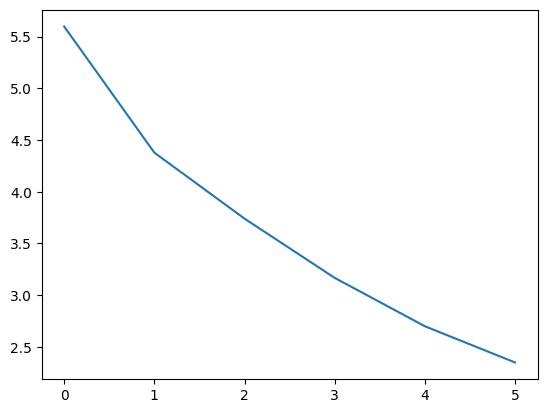

100%|██████████| 4585/4585 [01:37<00:00, 47.06it/s]


epoch:7  index:4585 loss:2.062495
source 障子 を 開ける 前 に 、 また 奥 さん を 振り返っ て 、 「 結婚 
target は
output に

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.10it/s]


epoch:8  index:4585 loss:1.822927
source の 顛末 を 詳しく ここ に 書く 事 の でき ない ほど 先 を 急い 
target で
output で

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.23it/s]


epoch:9  index:4585 loss:1.624680
source が 、 まだ 十 歳 の 少年 の 癖 に 、 大人 の 様 な 
target 恐怖
output 恐怖

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.44it/s]


epoch:10  index:4585 loss:1.454776
source に 調理 が 思う よう に 進み ませ ん 。 この 新しい 電子 書籍 リーダー 
target は
output は

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.58it/s]


epoch:11  index:4585 loss:1.308338
source 、 間接 に も 他人 の 知識 に は なら ない で 済ん だ でしょう 
target 。
output 。

Saved.


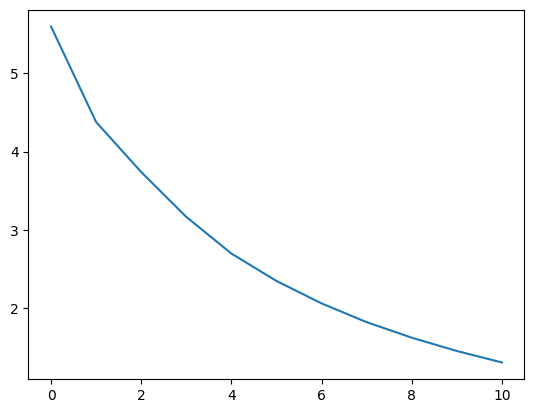

100%|██████████| 4585/4585 [01:36<00:00, 47.48it/s]


epoch:12  index:4585 loss:1.185324
source いくら 私 が 歩い て も 彼 を 動かす 事 は 到底 でき ない の 
target だ
output で

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.30it/s]


epoch:13  index:4585 loss:1.073328
source な もの で 節 十 何 番 目 か の ８ の 字 を 書い 
target て
output た

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.34it/s]


epoch:14  index:4585 loss:0.977832
source が 「 九 」 まで 進ん だ 時 、 もう 我慢 が し 切れ なく 
target なっ
output なっ

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.34it/s]


epoch:15  index:4585 loss:0.896504
source 的 な 協力 体制 を 構築 する こと で 、 <UNK> 技術 を 責任 ある 
target 開発
output 開発

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.37it/s]


epoch:16  index:4585 loss:0.826267
source やはり 気 に なっ て 、 家電 量販 店 にて 実物 を 見学 し た 
target ところ
output こと

Saved.


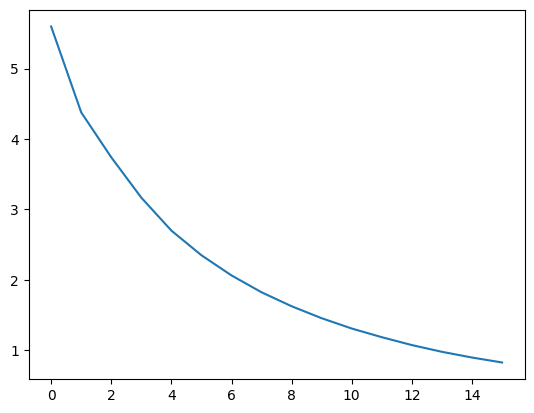

100%|██████████| 4585/4585 [01:37<00:00, 47.24it/s]


epoch:17  index:4585 loss:0.761928
source 、 こんな 森 とも 林 と も つか ぬ 空地 が 所々 に あっ て 
target 、
output 、

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.27it/s]


epoch:18  index:4585 loss:0.706257
source 方 へ 動い て 行こう と する 意気 組 に 卑しい ところ の 見える はず 
target は
output は

Saved.


100%|██████████| 4585/4585 [01:37<00:00, 47.21it/s]


epoch:19  index:4585 loss:0.655298
source 私 を 見 て 、 気の毒 そう に 外套 を 脱が せ て くれ たり 
target 、
output 、

Saved.


100%|██████████| 4585/4585 [01:36<00:00, 47.28it/s]


epoch:20  index:4585 loss:0.609645
source 置い た 蔵書 を 取寄せ 、 四方 の 壁 を 隙間 も なく 棚 に 
target し
output し

Saved.


In [72]:
#@title Train
model = model.to(device)
mask = mask.to(device)

# Epoch数まで繰り返し
for epoch in range(start_epoch, num_epochs):

    # 損失の累計をリセット
    running_loss = 0.0

    # 学習モードに変更
    model.train()

    # 学習データセット全体をバッチ単位で処理
    for i, batch in enumerate(tqdm(train_dataloader)):

        # 入力元データと教師データ
        source = batch['source'].to(device)
        target = batch['target'].to(device).view(-1)

        # 勾配のリセット
        optimizer.zero_grad()

        # 推論
        outputs, _, _ = model(source, None, mask)

        # 損失計算
        loss = criterion(outputs, target)

        # 誤差逆伝播
        loss.backward()

        # 学習パラメータの更新
        optimizer.step()

        # 損失の累積
        running_loss += loss.item()

    # 損失の履歴を作成
    train_loss = running_loss / len(train_dataloader)
    history["train_loss"].append(train_loss)

    # 開始epochの更新
    start_epoch = epoch

    # 損失の確認
    if epoch % 1 == 0:
        print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss:.6f}")
        evaluate.predict(source, target, outputs)

    # モデルの保存
    if epoch % 1 == 0 and epoch != 0:
        torch.save(model.state_dict(), pre_trained_model_path )
        print("Saved.")

    # グラフの描画
    if epoch % 5 == 0 and epoch != 0:
        plt.plot(history['train_loss'])
        plt.show()


# Test

In [76]:
sample_corpus = "この商品はおすすめできますが、温度調整が不安定で" #@param{type:"string"}
parsed_corpus = tagger.parse(sample_corpus)
seq_size = len(parsed_corpus.split())
mask = create_attention_mask(context_size )
# mask[:,seq_size:] = 0
Mask = None
print(parsed_corpus.split()[:context_size])
evaluate.generate2(parsed_corpus, model, mask)

['この', '商品', 'は', 'お', 'すすめ', 'でき', 'ます', 'が', '、', '温度', '調整', 'が', '不', '安定', 'で']
、効果が学習できる環境になりました。<UNK>はその時、デジタル教材の導入に向けて、いつからも存在する必要がある。だと、教材は、技術の高い教材を開発しており、情報格差の解消に倫理的な課題インターネット環境が重要である。関係者一丸となって取り組むことであった。一人ひとりが最適な学習環境を整備することが重要だ。##デジタル教材：利便性と質の向上を両立せよ近年、教育現場におけるデジタル教材の導入が加速している。文部科学省も積極的に推進しており、2024年度から小学校学習指導要領全面改訂に伴い、<UNK>スクール構想で整備されたタブレット端末を活用した授業が本格化する。デジタル教材は、従来の紙教材にはない利便性と備えている。動画や音声を3dモデルなどを活用した表現豊かな学習コンテンツを作成することができ、児童生徒の興味関心を高め、理解を深める効果が期待できるようになります学習や協調学習に適した機能も充実しております。aさん:ペースも、b氏と本当に、必ず髪を得てくれました。aさん:そうだね。本日はどうしたんだと思って、私の心のうちで、奥さんは到底私の方へはいって来るつもりだという事が恐ろしいような私を私は母のためにこんな事をよく知っていました。私はそのたびに聞いた。私はそれを知らなかったのです。私は彼のこの前から、こんな言葉を意味してくれる訳ですね」といい奥さんはもうすぐに「〇〇」私は二つのような口にしました。「どうしていい」といった風に若い顔を見た目の前に茶の間から立っていた。そうな訳だ。彼は彼の眼について、突然向うへと約束切りました。前後している綜合力だ。流石の自由にも、質のゾッとすることが、ここから、自然の中でも、質の高い場所を見つけたが可能になりません。すぐに過ぎたのだ。私の心は一層今まで何の深い